# EDFB - Digital Finance & Banking - Logistic Regression


---


The following script provides examples on how to train and test a logistic classifier in Python. In order to run the script, you need to download the datatset "banking.csv".




In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import os
import io
%matplotlib inline

In [ ]:
# To make this notebook's output stable across runs (we make the output reproducable)
np.random.seed(42)

In [ ]:
# Import real data
from google.colab import files
uploaded = files.upload()

Saving banking.csv to banking.csv


In [ ]:
dataset = pd.read_csv(io.BytesIO(uploaded['banking.csv']))

In [ ]:
dataset.shape

(41188, 17)

In [ ]:
dataset.dtypes

,0
age,int64
marital,object
education,object
housing,object
loan,object
contact,object
duration,int64
campaign,int64
pdays,int64
previous,int64


In [ ]:
# Define set of numerical and categorical variables
num_var = dataset.drop(columns=['y']).select_dtypes([np.number]).columns
cat_var = dataset.drop(columns=['y']).select_dtypes(include=object).columns

In [ ]:
num_var

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed'],
      dtype='object')

In [ ]:
cat_var

Index(['marital', 'education', 'housing', 'loan', 'contact', 'poutcome'], dtype='object')

In [ ]:
# Check NAs
dataset.isna().any()

,0
age,False
marital,False
education,False
housing,False
loan,False
contact,False
duration,False
campaign,False
pdays,False
previous,False


In [ ]:
# Get basic statistics for numerical variables
dataset.describe()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.112654
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528,0.316173
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


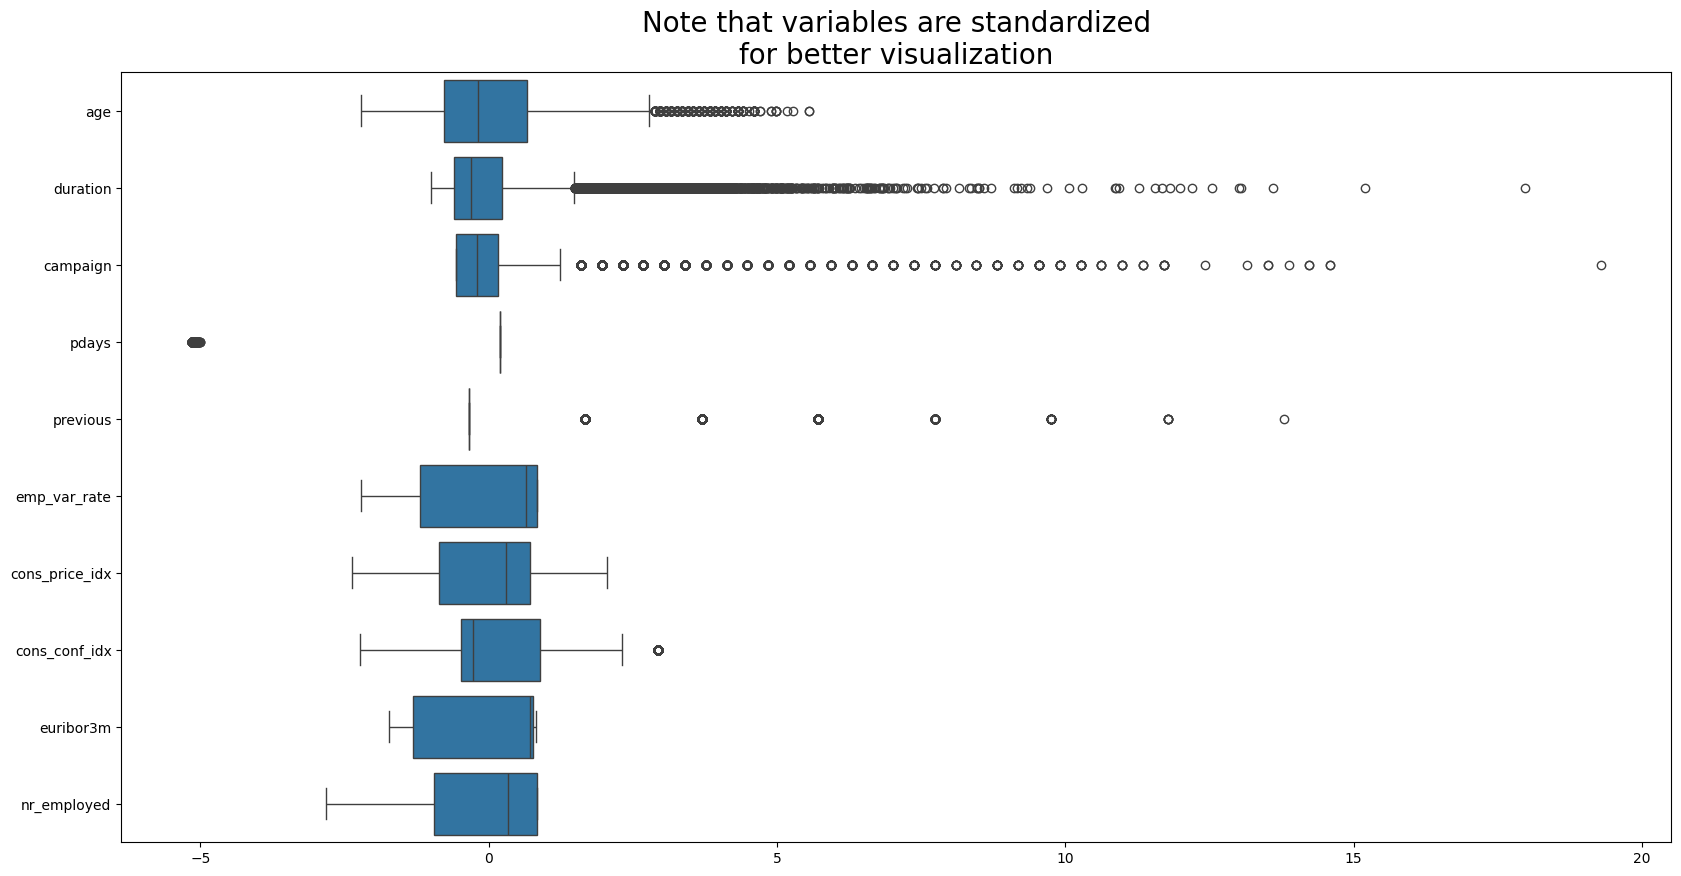

In [ ]:
# Check dispersion with box plot
from sklearn import preprocessing
def box_plot(df, standardize=True):

    fig=plt.figure(figsize=(20,10))

    if standardize==True:
        # standardize columns for better visualization
        df=pd.DataFrame(preprocessing.StandardScaler().fit_transform(df.values), columns = df.columns)
    fig=sns.boxplot(x='value', y='variable', data=pd.melt(df.reset_index(), id_vars='index', value_vars=list(df.columns)),
               orient='h')
    fig.tick_params(labelsize=10)
    fig.set_xlabel('')
    fig.set_ylabel('')
    fig.set_title('Note that variables are standardized\nfor better visualization', fontsize=20)
    plt.show()


box_plot(dataset[num_var], standardize=True)

In [ ]:
# We remove duration, pdays and previous
dataset=dataset.drop(columns=['duration', 'pdays', 'age', 'campaign', 'previous'])
num_var= dataset.drop(columns=['y']).select_dtypes([np.number]).columns

<Figure size 1000x1000 with 0 Axes>

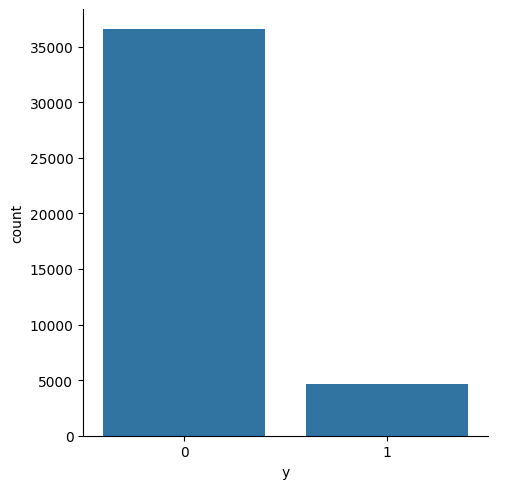

In [ ]:
# Check distribution for target variable
plt.figure(figsize=(10,10))
sns.catplot(x='y', kind="count", data=dataset) # categorical plots
plt.show()

In [ ]:
# Dataset is very unbalanced so we remove some observation for y=0 to be equal to 2*size of y=1.
# This is called "undersampling"

# We keep all y=1
from sklearn.model_selection import train_test_split
data_1 = dataset[dataset['y'] == 1]
print(data_1.shape)

# We take y=0 as double the size of data_1
# Moreover we "stratify" the sampling in order to take the same distribution for each variable
# We use the train_test_split function and we keep the test only
all_data_0 = dataset[dataset['y'] == 0]
percentage_corresponding_to_double_size = 2*data_1.shape[0] / all_data_0.shape[0] # 2*size_1 compared to size_0

X = all_data_0.drop(columns=['y'])
y = all_data_0['y'].to_frame()

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)
data_0_big, data_0_small = train_test_split(all_data_0, test_size=percentage_corresponding_to_double_size,
                                                    random_state=0, shuffle=True)
print(data_0_big.shape) # remaining from the dataset
print(data_0_small.shape)


(4640, 12)
(27268, 12)
(9280, 12)


In [ ]:
# Merge two dataset

dataset=pd.concat([data_1, data_0_small], axis= 0).reset_index(drop=True)  # axis = 1 by column and = 0 by row
print(dataset.shape)

(13920, 12)


<Figure size 1000x1000 with 0 Axes>

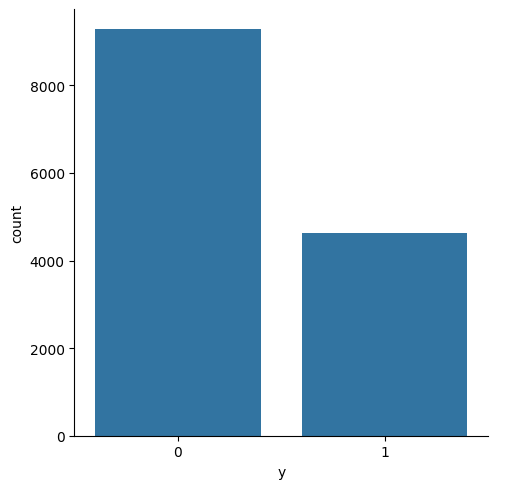

In [ ]:
# Check distribution for target variable after downsampling

plt.figure(figsize=(10,10))
sns.catplot(x='y', kind="count", data=dataset)
plt.show()

<ipython-input-18-5a5798676d9c>:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_1[var], label='1', ax=ax)
<ipython-input-18-5a5798676d9c>:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_0[var], label='0', ax=ax)
<ipython-input-18-5a5798676d9c>:15: UserWarning: 

`distplot` is a deprecate

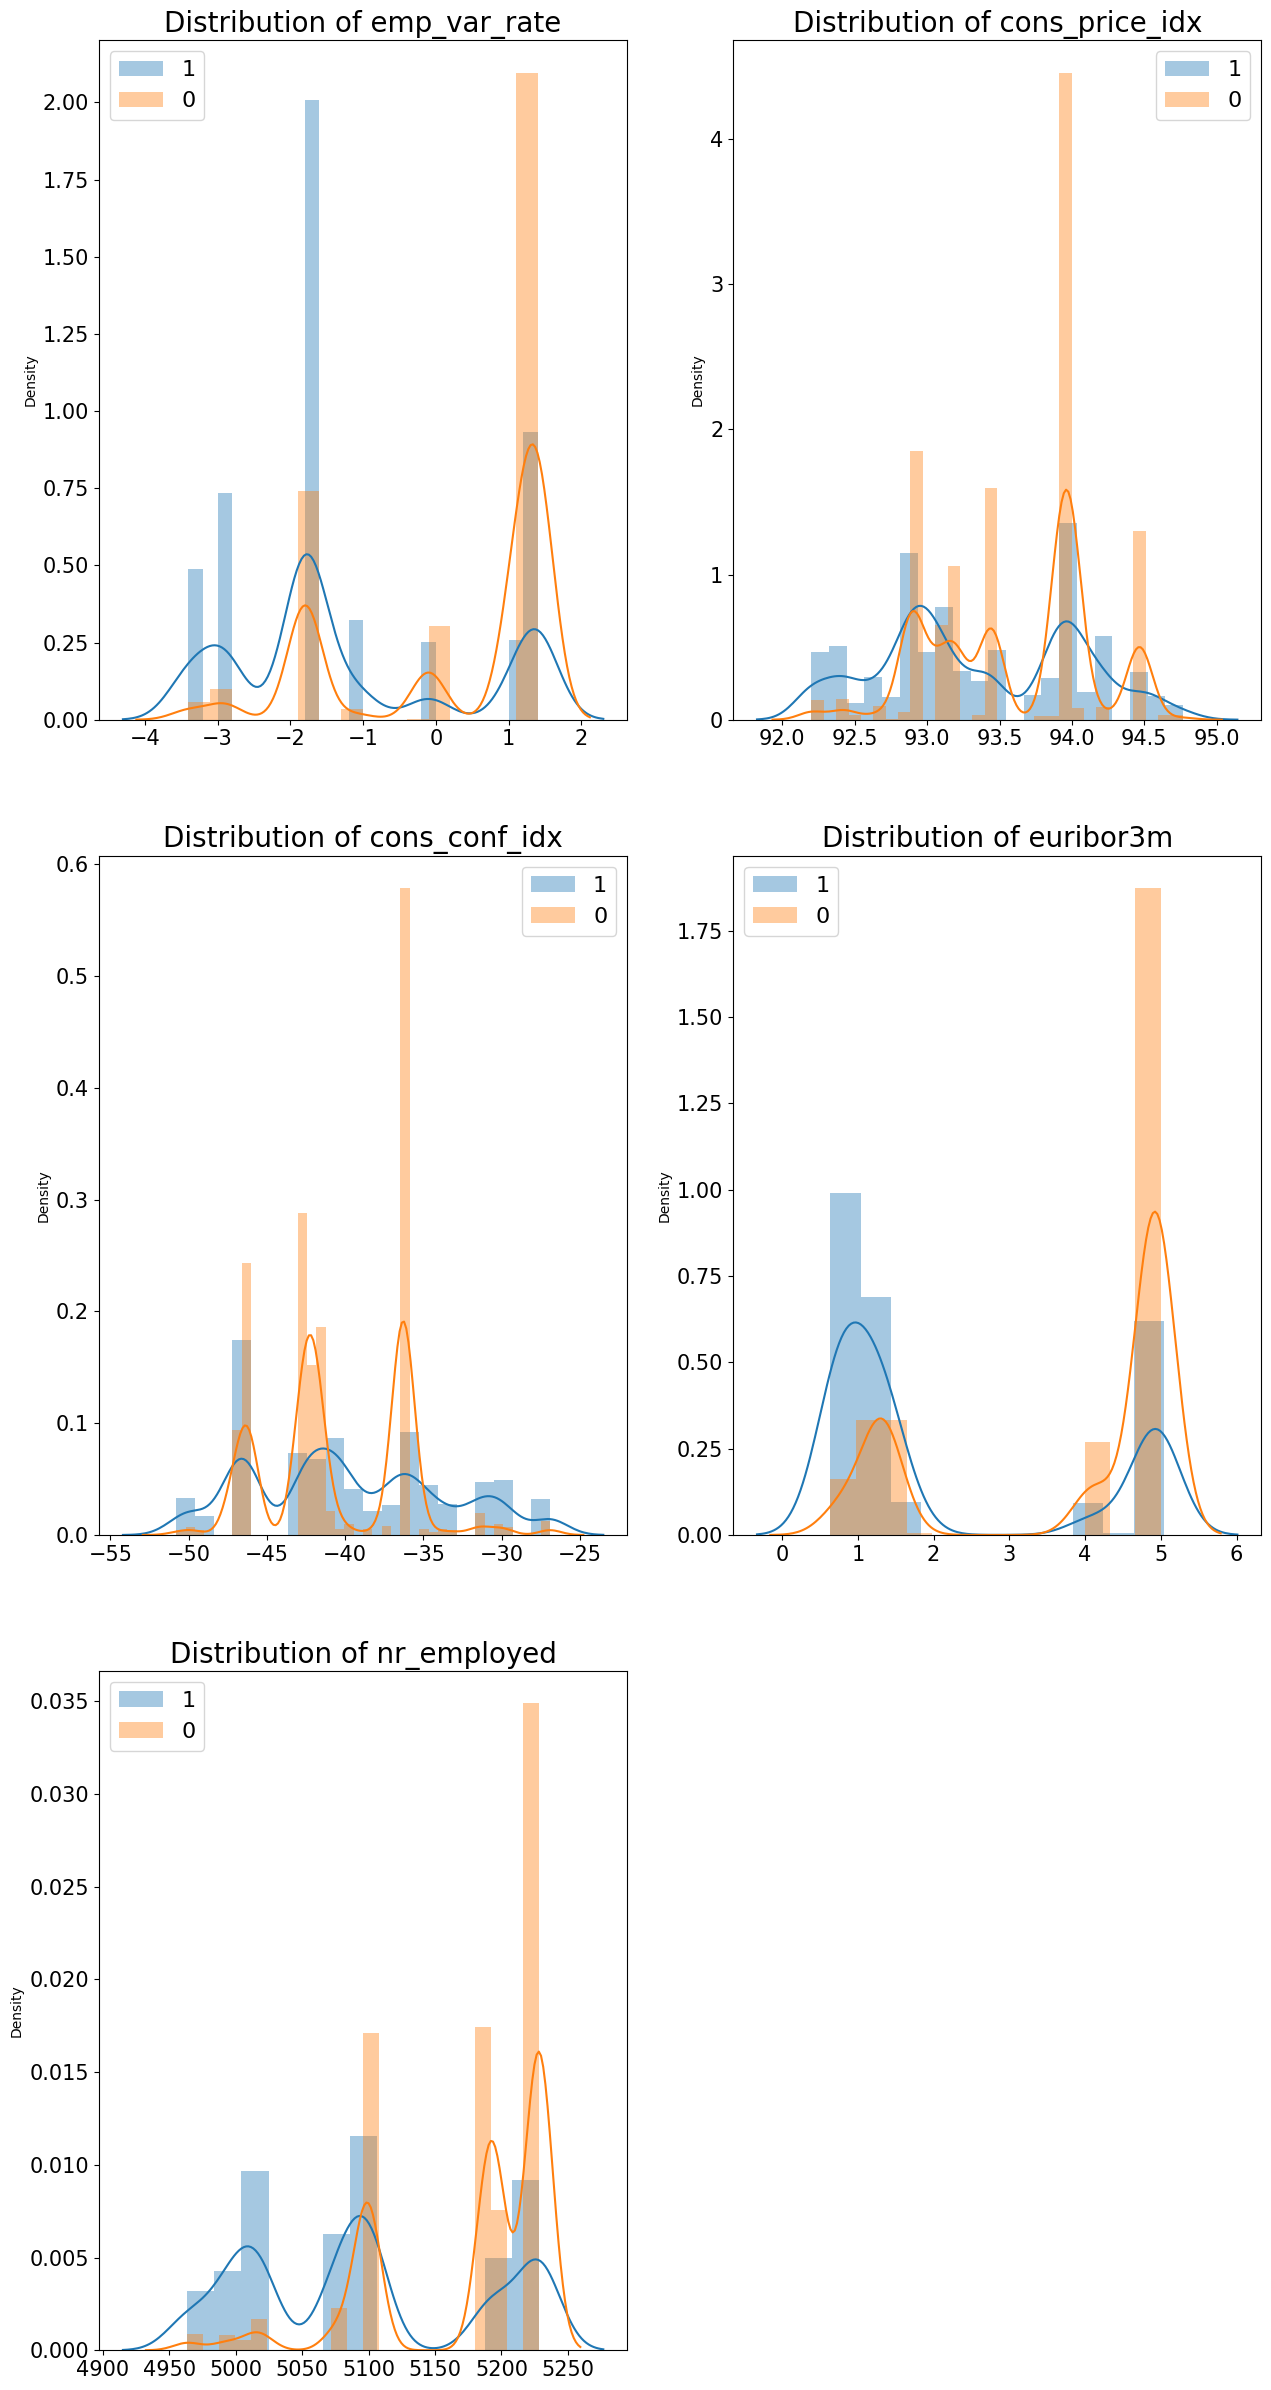

In [ ]:
# Plot the distribution and the boxplot of the numerical variables included in the dataset compared to the target (it's only 0 or 1)

fig = plt.figure(figsize=(15,30))
plot_count=1

# scale variable for better visualizing boxplot
dataset_scaled=pd.DataFrame(preprocessing.StandardScaler().fit_transform(dataset[num_var].values),columns = num_var)
dataset_scaled['y']=dataset['y'].astype(str)
y_1 = dataset.loc[dataset['y'] == 1] #.loc - access group of values using labels.
y_0 = dataset.loc[dataset['y'] == 0]

for var in num_var:
    # plot variable distribution
    ax = fig.add_subplot(math.ceil(len(num_var) / 2), 2, plot_count)
    sns.distplot(y_1[var], label='1', ax=ax)
    sns.distplot(y_0[var], label='0', ax=ax)
    ax.set_title('Distribution of ' + var, fontsize=20)
    ax.tick_params(labelsize=15)
    ax.set_xlabel('')
    ax.legend(fontsize=16)
    plot_count += 1


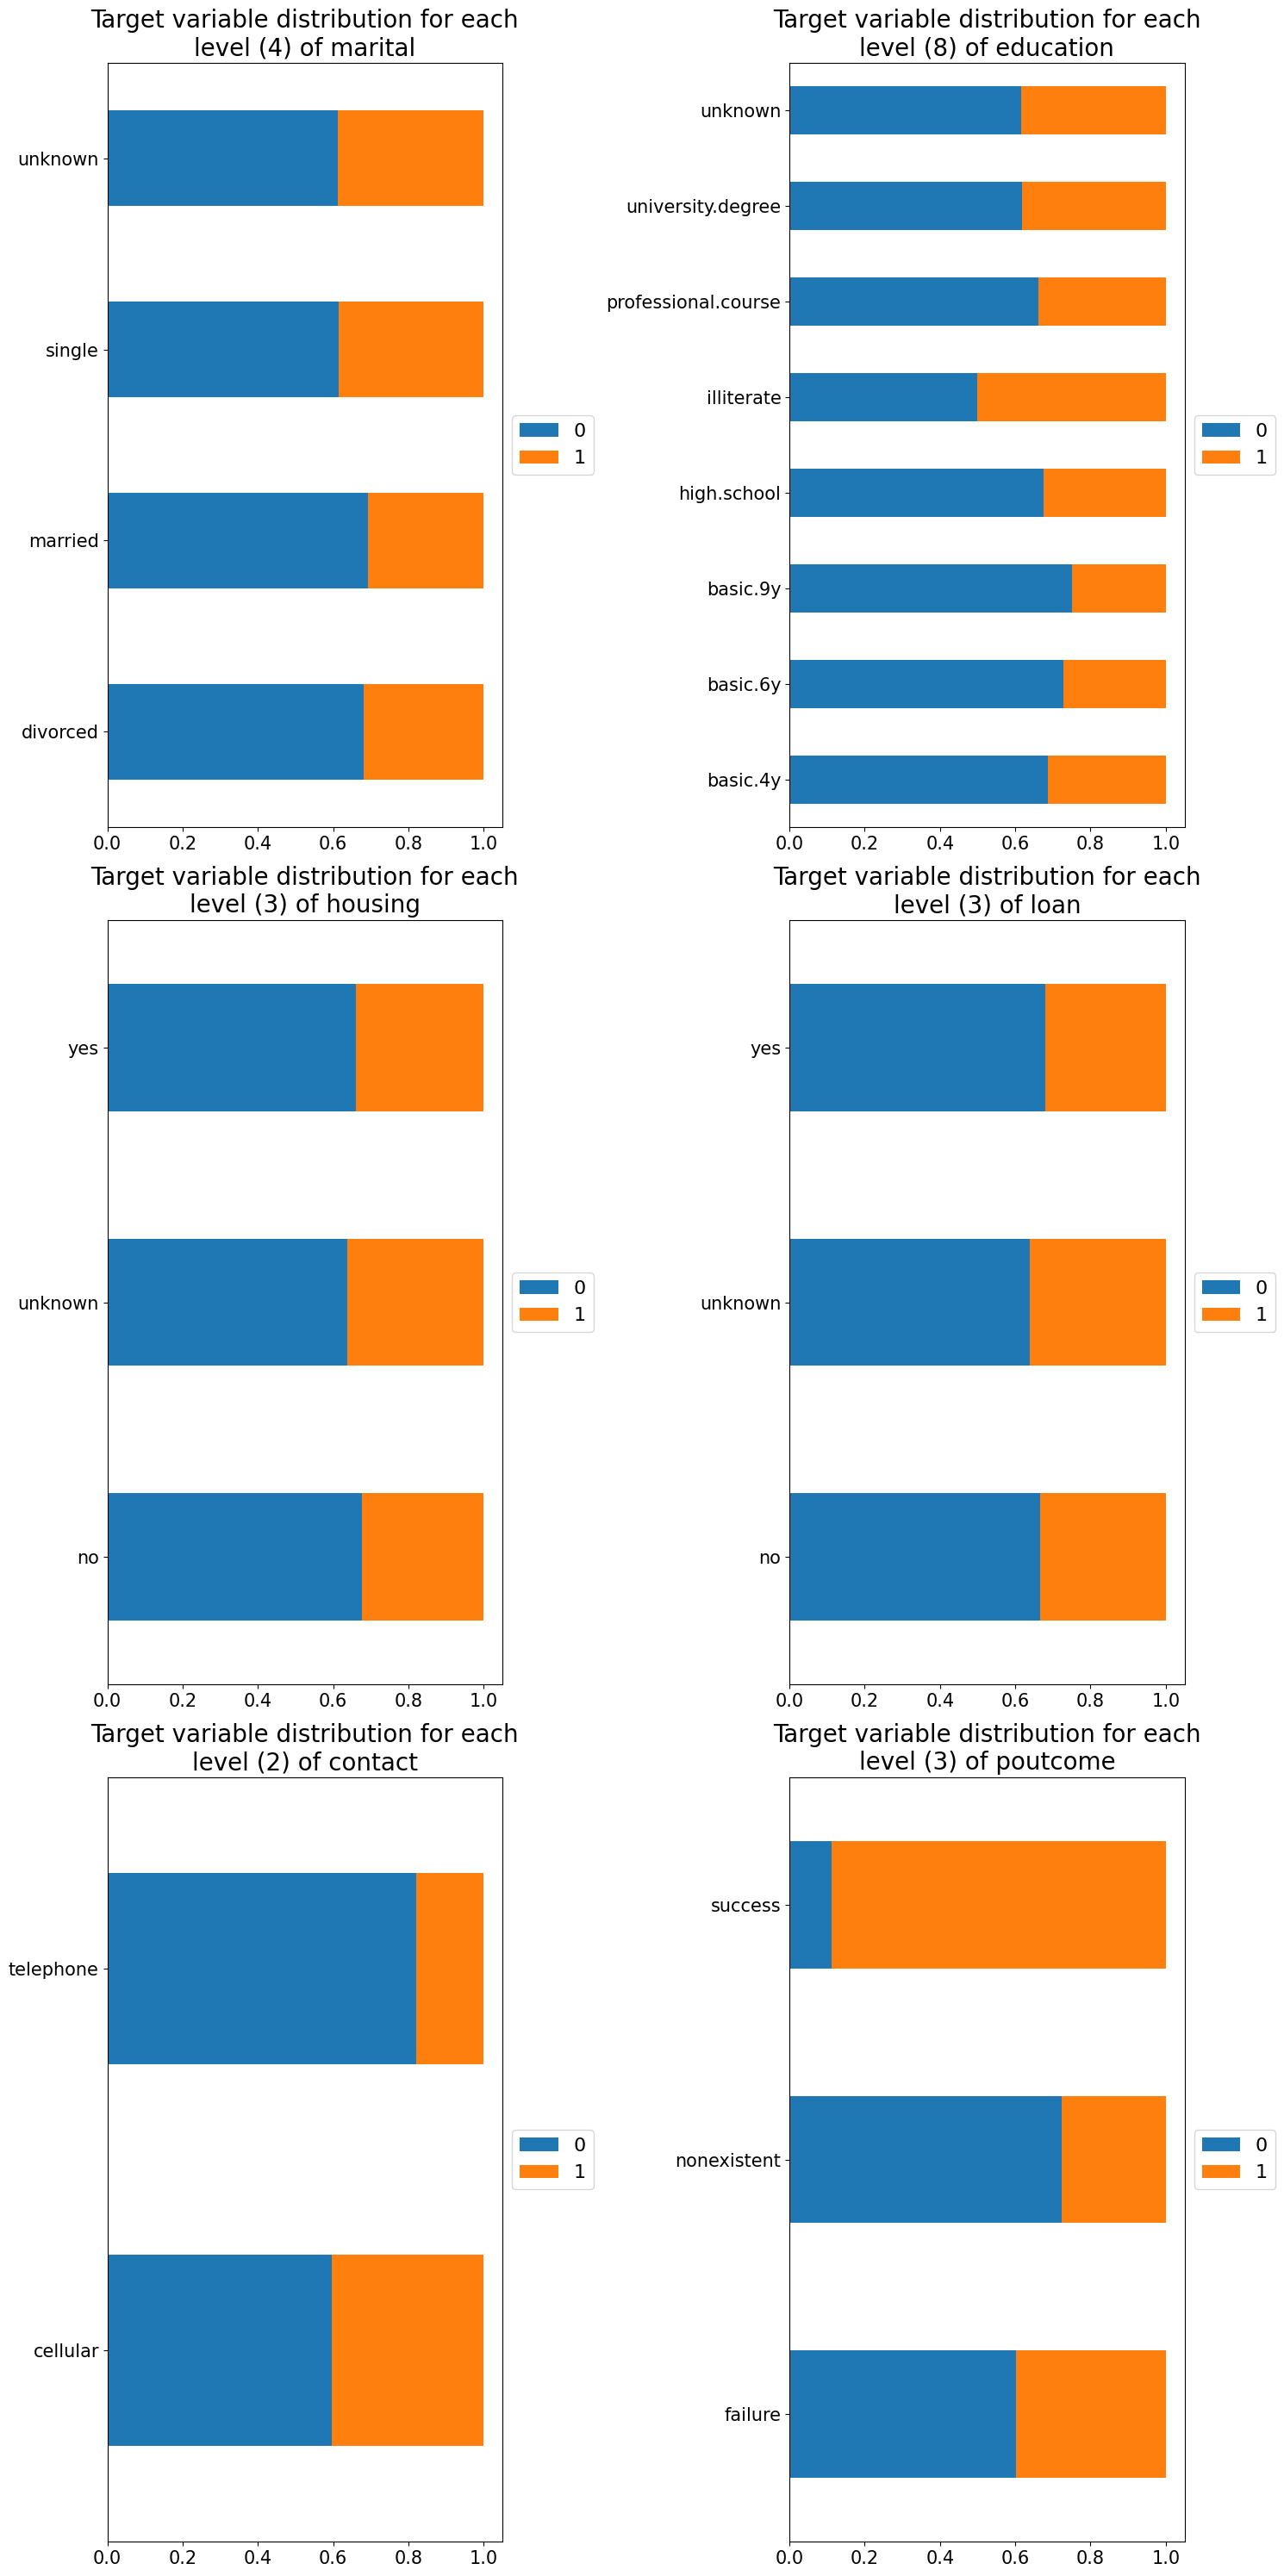

In [ ]:
# Check the distribution of the levels of the categorical variables compared with the target

fig = plt.figure(figsize=(15,30))
plot_count=1

for var in cat_var:
    # plot variable distribution
    ax = fig.add_subplot(math.ceil(len(cat_var) / 2), 2, plot_count)
    plot_set = dataset.groupby([var, 'y']).size().reset_index().pivot(columns='y', index=var, values=0)
    plot_set=plot_set.div(plot_set.sum(axis=1), axis=0).plot(kind='barh', stacked=True, ax=ax)
    ax.set_title('Target variable distribution for each\nlevel (' + str(len(dataset[var].unique())) +
                 ') of ' + var, fontsize=20)
    ax.tick_params(labelsize=15)
    ax.set_ylabel('')
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=16)
    plot_count += 1
plt.tight_layout()
plt.show()

In [ ]:
dataset.head()

,marital,education,housing,loan,contact,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,single,university.degree,yes,no,cellular,success,-1.7,94.055,-39.8,0.729,4991.6,1
1,married,basic.4y,yes,no,cellular,success,-2.9,92.201,-31.4,0.869,5076.2,1
2,married,university.degree,no,no,cellular,success,-2.9,92.963,-40.8,1.266,5076.2,1
3,married,university.degree,no,no,cellular,nonexistent,1.4,93.444,-36.1,4.965,5228.1,1
4,married,high.school,no,no,cellular,nonexistent,-1.8,93.075,-47.1,1.365,5099.1,1


In [ ]:
# Create dummy variables & standardize the dataset
dataset_dummy=pd.get_dummies(dataset.copy(), dummy_na=False, drop_first=True) # Whether to get k-1 dummies out of k categorical levels by removing the first level.
dataset_dummy[num_var]=pd.DataFrame(preprocessing.StandardScaler().fit_transform(dataset[num_var].values),columns = num_var)

In [ ]:
dataset_dummy.head()

,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y,marital_married,marital_single,marital_unknown,education_basic.6y,...,education_professional.course,education_university.degree,education_unknown,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,poutcome_nonexistent,poutcome_success
0,-0.865499,0.875629,0.103098,-1.359649,-1.908513,1,False,True,False,False,...,False,True,False,False,True,False,False,False,False,True
1,-1.578404,-2.164521,1.761441,-1.284113,-0.882935,1,True,False,False,False,...,False,False,False,False,True,False,False,False,False,True
2,-1.578404,-0.915009,-0.094324,-1.069914,-0.882935,1,True,False,False,False,...,False,True,False,False,False,False,False,False,False,True
3,0.976173,-0.126276,0.833559,0.925858,0.958499,1,True,False,False,False,...,False,True,False,False,False,False,False,False,True,False
4,-0.924907,-0.731354,-1.338082,-1.016499,-0.605326,1,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [ ]:
# Check the correlations between variables
corrmat = dataset_dummy.corr()


In [ ]:
# Correlation matrix in key-values pairs
corrmat *= np.where(np.tri(*corrmat.shape, k=-1)==0, np.nan, 1)  # puts NaN on upper triangular matrix, including diagonal (k=-1)
corrmat_list=corrmat.unstack().to_frame()

# Check highest correlations
corrmat_list.columns=['correlation']
corrmat_list['abs_corr']=corrmat_list.correlation.abs()
corrmat_list.sort_values(by=['abs_corr'], ascending=False, na_position='last', inplace=True)
corrmat_list.drop(columns=['abs_corr']).head(10)


,,correlation
housing_unknown,loan_unknown,1.000000
emp_var_rate,euribor3m,0.965032
euribor3m,nr_employed,0.942938
emp_var_rate,nr_employed,0.885178
marital_married,marital_single,-0.787111
emp_var_rate,cons_price_idx,0.740706
cons_price_idx,euribor3m,0.618069
poutcome_nonexistent,poutcome_success,-0.593410
nr_employed,poutcome_nonexistent,0.532803
cons_price_idx,contact_telephone,0.529416


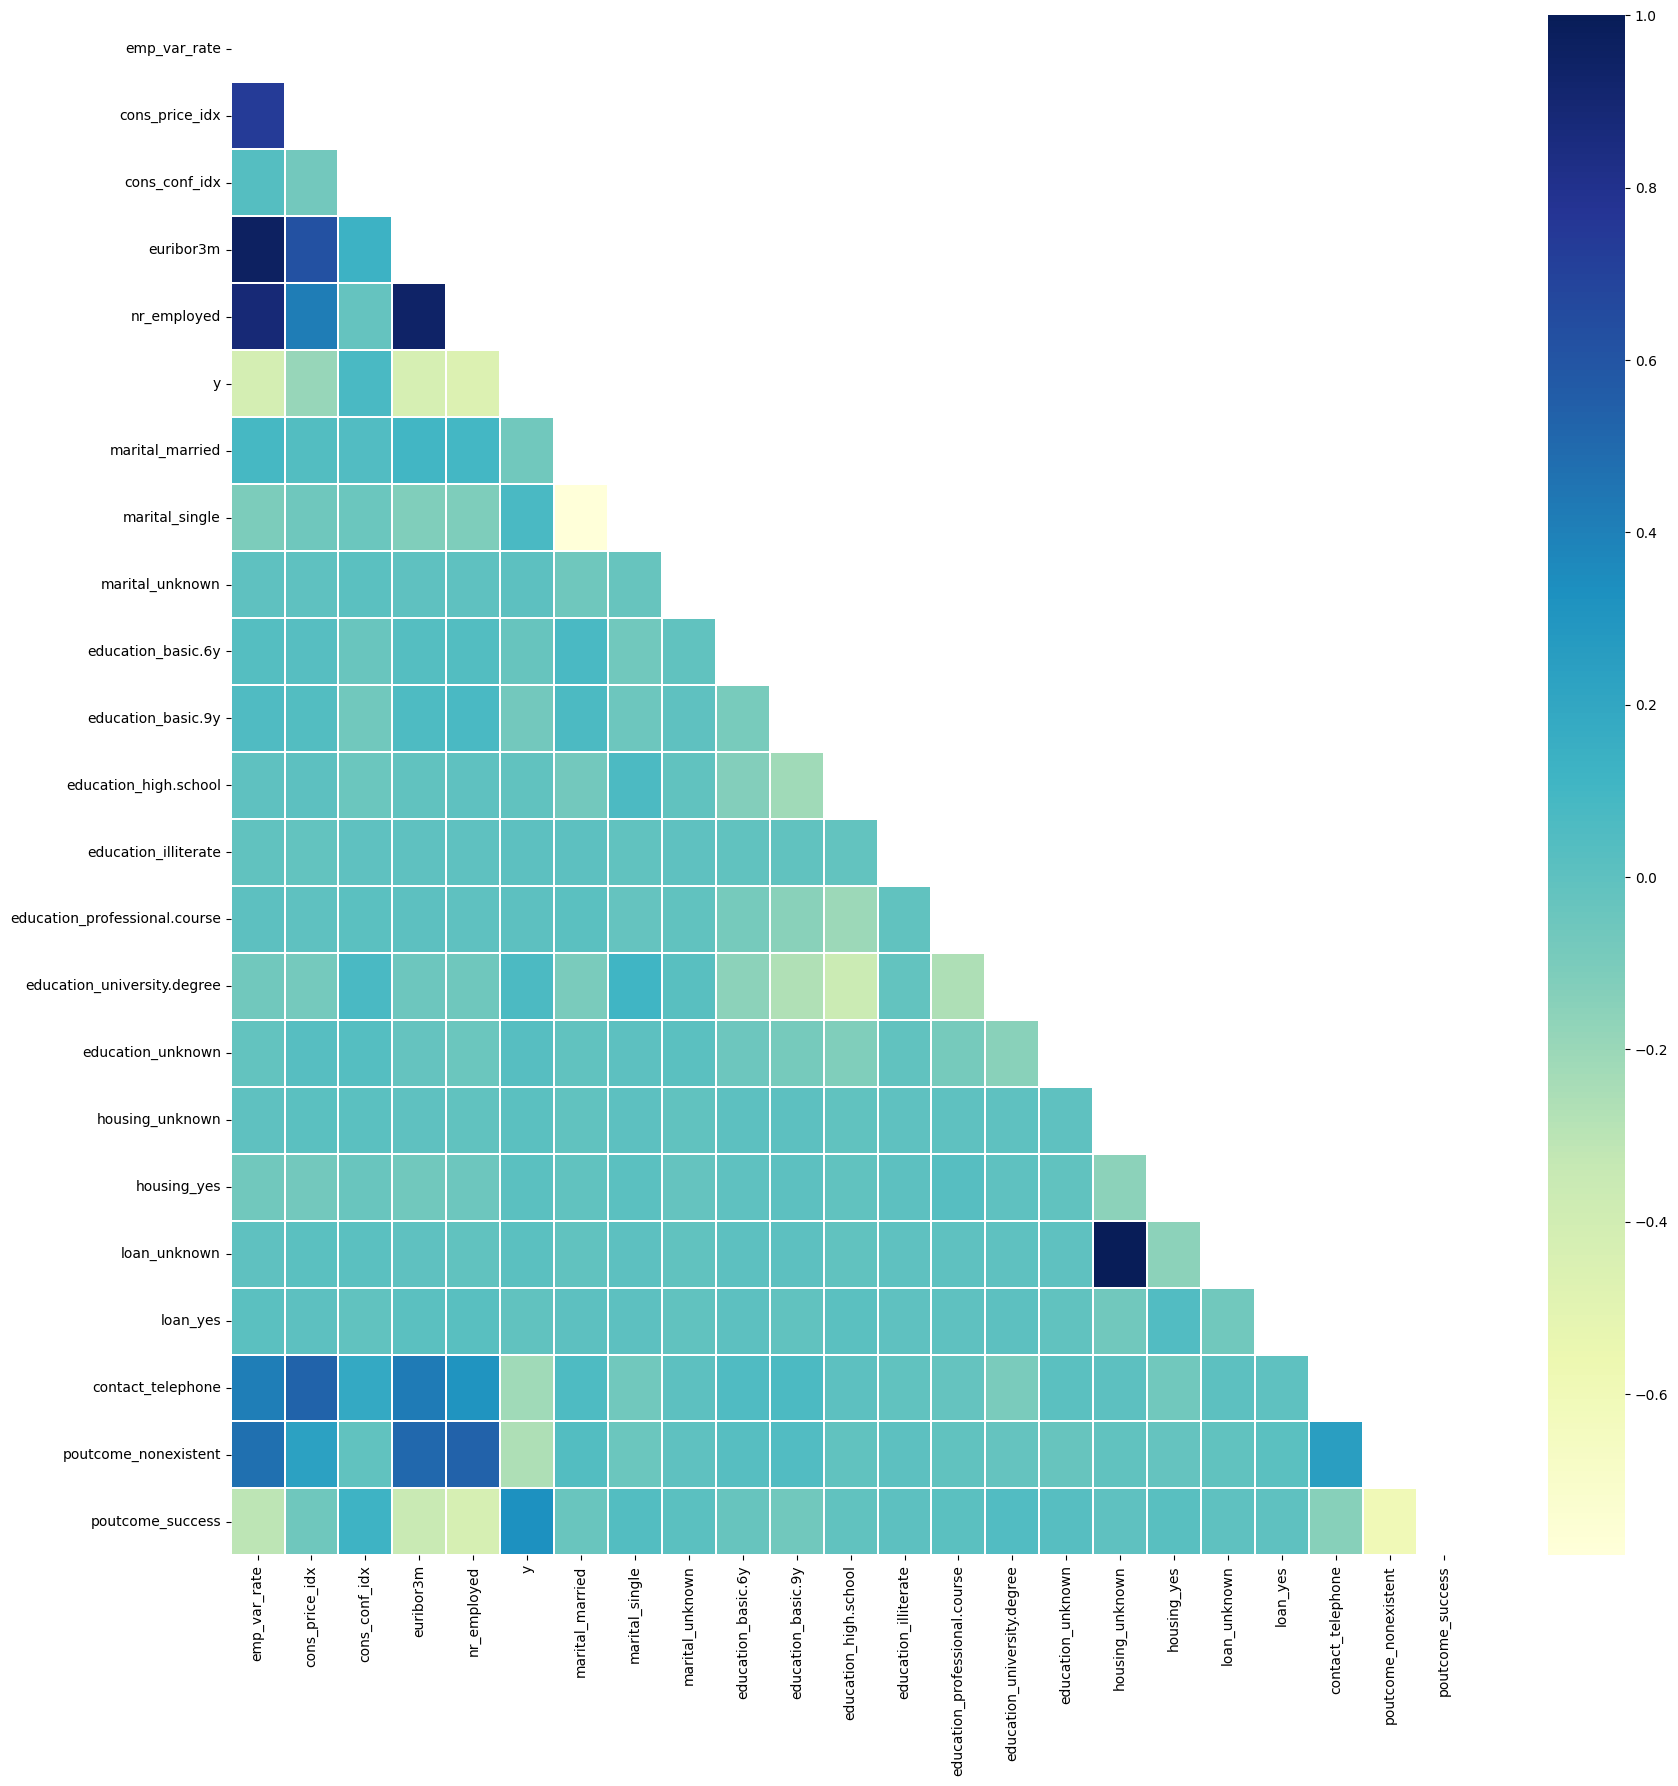

In [ ]:
# Plot correlation heatmap
plt.figure(figsize=(20,20))
sns.heatmap(corrmat, cmap ="YlGnBu", linewidths = 0.1)
plt.show()

In [ ]:
# Drop highly correlated columns
dataset_original=dataset.copy() # save original dataset

# Rename dataset_dummy and drop columns
col_to_drop=['emp_var_rate', 'cons_price_idx', 'euribor3m', 'nr_employed', 'loan_unknown', 'housing_unknown']
dataset=dataset_dummy.drop(columns=col_to_drop)
num_var=dataset.columns.intersection(num_var)

In [ ]:
# Ready to train and test our clasifer!
X = dataset.drop(columns=['y'])
y = dataset['y'].values
print(X.shape)
print(y.shape)

(13920, 16)
(13920,)


In [ ]:
# Split train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=dataset['y'])
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(11136, 16)
(2784, 16)
(11136,)
(2784,)


In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', random_state=0) # solver (https://towardsdatascience.com/dont-sweat-the-solver-stuff-aea7cddc3451)
model.fit(X_train, y_train) # training the algorithm

LogisticRegression(random_state=0)

In [ ]:
# Get fitted value on test set
y_test_predicted = model.predict(X_test)

# Compare predictions
display(pd.DataFrame({'True': y_test.flatten(), 'Predicted': y_test_predicted.flatten()}))

# Compare predicted probabilities (default threshold for converting to 0 or 1 is 0.5)
y_test_predicted_prob = model.predict_proba(X_test)[:,1]
display(pd.DataFrame({'True': y_test.flatten(), 'Predicted_prob': y_test_predicted_prob.flatten(), 'Predicted': y_test_predicted.flatten()}))

,True,Predicted
0,0,0
1,0,0
2,0,0
3,1,0
4,0,0
...,...,...
2779,0,0
2780,0,0
2781,0,0
2782,0,0


,True,Predicted_prob,Predicted
0,0,0.209110,0
1,0,0.206016,0
2,0,0.347196,0
3,1,0.157984,0
4,0,0.284386,0
...,...,...,...
2779,0,0.386362,0
2780,0,0.286905,0
2781,0,0.351572,0
2782,0,0.157401,0


In [ ]:
# Evaluate confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_test_predicted)

array([[1813,   43],
       [ 721,  207]])

Confusion matrix, without normalization
[[1813   43]
 [ 721  207]]


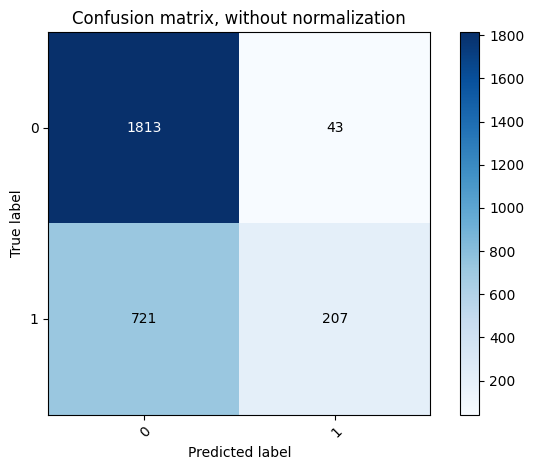

In [ ]:
# Evaluate confusion matrix

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Only use the labels that appear in the data
    classes = ['0', '1']
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_test_predicted)
plt.show()

In [ ]:
# Evaluate precision, recall, F1-score on train set
# A macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally),
# whereas a micro-average will aggregate the contributions of all classes to compute the average metric.
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_predicted))

              precision    recall  f1-score   support

           0       0.72      0.98      0.83      1856
           1       0.83      0.22      0.35       928

    accuracy                           0.73      2784
   macro avg       0.77      0.60      0.59      2784
weighted avg       0.75      0.73      0.67      2784



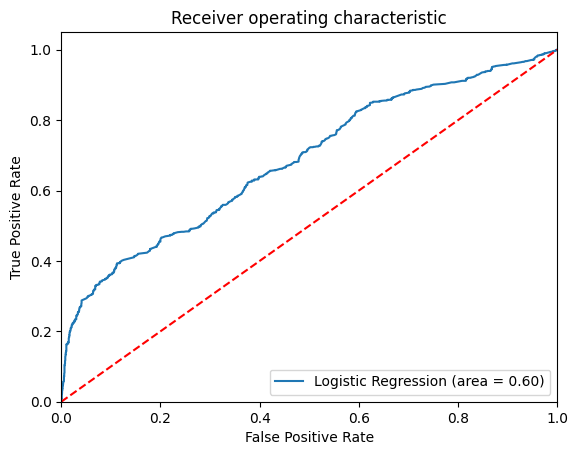

In [ ]:
# Evaluate ROC curve

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, y_test_predicted)
fpr, tpr, thresholds = roc_curve(y_test, y_test_predicted_prob)


plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()